In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [5]:
# Loading the Financial Dataset
fin_data = pd.read_csv("compustat_2000_clean.csv", na_values = ["NA", "na", "?"], low_memory = False)

In [7]:
fin_data = fin_data.dropna(axis=1)
fin_data.shape

(235996, 301)

In [65]:
# Define the selected 10 variables
selected_columns = ["at", "ni", "revt", "ceq", "epspx", "capx", "oibdp", "wcap", "dltt", "xsga"]

# Slice the DataFrame to include only these columns
fin_data_selected = fin_data[selected_columns].iloc[:10000]

# Display the first few rows
print(fin_data_selected.head())

        at      ni     revt      ceq  epspx    capx   oibdp     wcap     dltt  \
0  701.854  18.531  874.255  340.212   0.69  13.134  64.367  360.464  179.987   
1  710.199 -58.939  638.721  310.235  -2.08  12.112  27.207  286.192  217.699   
2  686.621 -12.410  606.337  294.988  -0.39   9.930  30.745  192.837  164.658   
3  709.292   3.504  651.958  301.684   0.11  10.286  47.491  300.943  248.666   
4  732.230  15.453  747.848  314.744   0.58  13.033  61.774  314.517  227.159   

     xsga  
0  96.077  
1  85.037  
2  78.845  
3  81.165  
4  87.902  


In [105]:
from scipy.stats.mstats import winsorize
import numpy as np

#Finds the values for 1st percentile and 95th percentile
epspx_lower, epspx_upper = np.percentile(fin_data_selected["epspx"].dropna(), [1, 95])
wcap_lower, wcap_upper = np.percentile(fin_data_selected["wcap"].dropna(), [1, 95])

print(f"Earnings per Share (epspx) Winsorization Limits: {epspx_lower} to {epspx_upper}")
print(f"Working Capital (wcap) Winsorization Limits: {wcap_lower} to {wcap_upper}")

Earnings per Share (epspx) Winsorization Limits: -10.3402 to 7.36
Working Capital (wcap) Winsorization Limits: -4470.3099999999995 to 2962.3796999999977


In [107]:
# Apply Winsorization using clip() for exact percentile-based capping
fin_data_selected["epspx_winsorized"] = fin_data_selected["epspx"].clip(lower=-10.3402, upper=7.36)
fin_data_selected["wcap_winsorized"] = fin_data_selected["wcap"].clip(lower=-4470.31, upper=2962.38)

In [109]:
# Select features for clustering
features = fin_data_selected[['epspx_winsorized', 'wcap_winsorized']]
features = features.iloc[:10000]

In [111]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_scaled.shape

(10000, 2)

In [113]:
# Generate the linkage matrix for dendrogram
linked = linkage(X_scaled, method='ward')

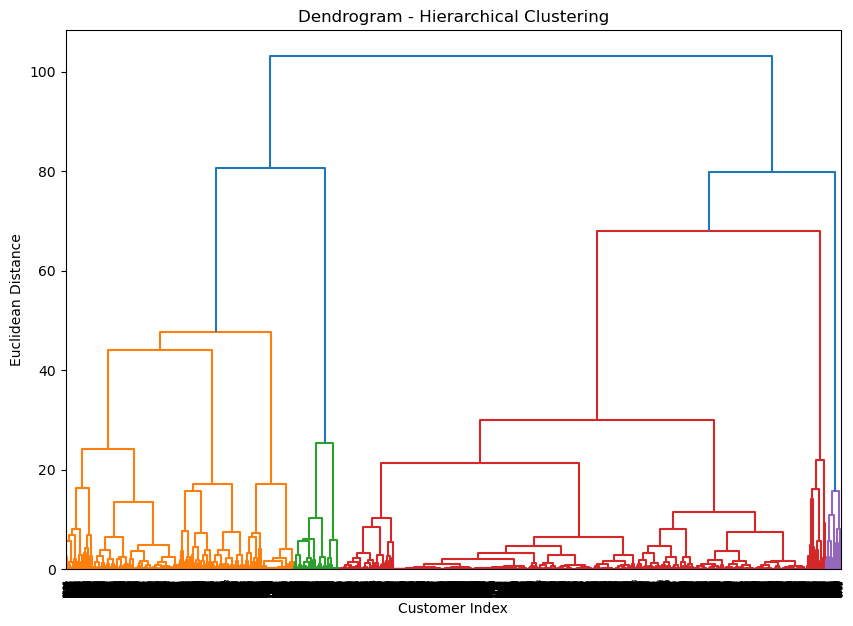

In [115]:
# Plot the dendrogram to determine the optimal number of clusters
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Customer Index')
plt.ylabel('Euclidean Distance')
plt.show()

In [117]:
# From the dendrogram, choose k=4 clusters
k = 4

# Initialize Hierarchical Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')

In [119]:
# Fit and predict cluster assignments
clusters = hc.fit_predict(X_scaled)

In [133]:
# Add cluster assignments to the original dataframe
features['Cluster'] = clusters

In [135]:
# Evaluate clustering performance using Silhouette Score
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"\nSilhouette Score for k={k}: {silhouette_avg:.2f}")


Silhouette Score for k=4: 0.46


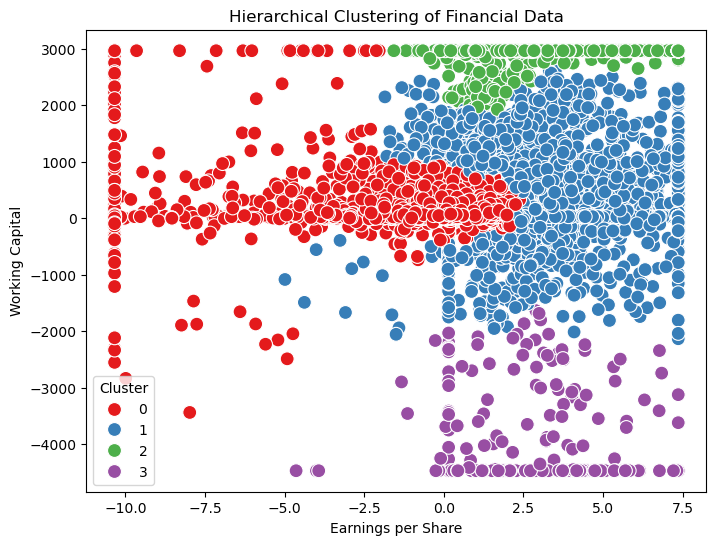


Cluster Statistics:
         epspx_winsorized  wcap_winsorized
Cluster                                   
0               -0.060577       107.199280
1                3.698186       324.959032
2                3.292698      2883.700885
3                2.897310     -3802.928188


In [137]:
# Visualize the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='epspx_winsorized',
    y='wcap_winsorized',
    hue='Cluster',
    palette='Set1',
    data=features,
    s=100
)
plt.title('Hierarchical Clustering of Financial Data')
plt.xlabel('Earnings per Share')
plt.ylabel('Working Capital')
plt.legend(title='Cluster')
plt.show()

# Display cluster statistics
print("\nCluster Statistics:")
print(features.groupby('Cluster').mean())